# Naives Bayes (get a probability of a comment being 'sarcasm' or 'bullying' given 'a word'  is in this comment)

In [1]:
import numpy as np 
import pandas as pd
from nltk.corpus import stopwords 
from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix


## Fetching the dataset

In [2]:
merged_df = pd.read_csv('merged_all_csv.csv')

In [3]:
merged_df

,Unnamed: 0,label,comment,comment_cleaned,Words Per Tweet
0,44,sarcasm,wow it is totally unreasonable to assume that ...,wow it is totally unreasonable to assume that ...,25.0
1,443,sarcasm,A WHITE FUCKIN MALE is out to destroy 2 strong...,"a WHITE FUCKIN MALE is out to destroy strong,...",18.0
2,807,sarcasm,He probably just didn't want to read them beca...,he probably just didn't want to read them beca...,23.0
3,1745,sarcasm,It's like he's saying we're entering a post ge...,it's like he's saying we're entering a post ge...,21.0
4,2022,sarcasm,But it was clearly only dismissed because of d...,but it was clearly only dismissed because of d...,19.0
...,...,...,...,...,...
42497,47687,ethnicity,"Black ppl aren't expected to do anything, depe...","black ppl aren't expected to do anything, depe...",42.0
42498,47688,ethnicity,Turner did not withhold his disappointment. Tu...,turner did not withhold his disappointment. Tu...,45.0
42499,47689,ethnicity,I swear to God. This dumb nigger bitch. I have...,i swear to God. This dumb nigger bitch. I have...,20.0
42500,47690,ethnicity,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,yea fuck you RT IF YOURE A NIGGER FUCKING UNF...,15.0


In [4]:
merged_df = merged_df[['label', 'comment_cleaned', 'Words Per Tweet']]
merged_df.dtypes

label               object
comment_cleaned     object
Words Per Tweet    float64
dtype: object

In [5]:
merged_df['comment_cleaned'] = merged_df['comment_cleaned'].astype(str)

## Lowercasing the dataset

In [6]:
merged_df['comment_cleaned_lower'] = merged_df['comment_cleaned'].str.lower()
merged_df

,label,comment_cleaned,Words Per Tweet,comment_cleaned_lower
0,sarcasm,wow it is totally unreasonable to assume that ...,25.0,wow it is totally unreasonable to assume that ...
1,sarcasm,"a WHITE FUCKIN MALE is out to destroy strong,...",18.0,"a white fuckin male is out to destroy strong,..."
2,sarcasm,he probably just didn't want to read them beca...,23.0,he probably just didn't want to read them beca...
3,sarcasm,it's like he's saying we're entering a post ge...,21.0,it's like he's saying we're entering a post ge...
4,sarcasm,but it was clearly only dismissed because of d...,19.0,but it was clearly only dismissed because of d...
...,...,...,...,...
42497,ethnicity,"black ppl aren't expected to do anything, depe...",42.0,"black ppl aren't expected to do anything, depe..."
42498,ethnicity,turner did not withhold his disappointment. Tu...,45.0,turner did not withhold his disappointment. tu...
42499,ethnicity,i swear to God. This dumb nigger bitch. I have...,20.0,i swear to god. this dumb nigger bitch. i have...
42500,ethnicity,yea fuck you RT IF YOURE A NIGGER FUCKING UNF...,15.0,yea fuck you rt if youre a nigger fucking unf...


## Getting the most frequent words

The most frequent words are for sure going to be stop words, so in order to find frequent occurences of meaningful words, let's create a new column which will contain the comment without the stopwords.

In [7]:
stop_words = set(stopwords.words('english')) 
merged_df['text_without_stop_words'] = merged_df['comment_cleaned_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

merged_df

,label,comment_cleaned,Words Per Tweet,comment_cleaned_lower,text_without_stop_words
0,sarcasm,wow it is totally unreasonable to assume that ...,25.0,wow it is totally unreasonable to assume that ...,wow totally unreasonable assume agency covered...
1,sarcasm,"a WHITE FUCKIN MALE is out to destroy strong,...",18.0,"a white fuckin male is out to destroy strong,...","white fuckin male destroy strong, independent ..."
2,sarcasm,he probably just didn't want to read them beca...,23.0,he probably just didn't want to read them beca...,probably want read illegal read news media see...
3,sarcasm,it's like he's saying we're entering a post ge...,21.0,it's like he's saying we're entering a post ge...,like he's saying we're entering post gender so...
4,sarcasm,but it was clearly only dismissed because of d...,19.0,but it was clearly only dismissed because of d...,clearly dismissed death threats even though li...
...,...,...,...,...,...
42497,ethnicity,"black ppl aren't expected to do anything, depe...",42.0,"black ppl aren't expected to do anything, depe...","black ppl expected anything, depended anything..."
42498,ethnicity,turner did not withhold his disappointment. Tu...,45.0,turner did not withhold his disappointment. tu...,turner withhold disappointment. turner called ...
42499,ethnicity,i swear to God. This dumb nigger bitch. I have...,20.0,i swear to god. this dumb nigger bitch. i have...,swear god. dumb nigger bitch. got bleach hair ...
42500,ethnicity,yea fuck you RT IF YOURE A NIGGER FUCKING UNF...,15.0,yea fuck you rt if youre a nigger fucking unf...,"yea fuck rt youre nigger fucking unfollow me, ..."


In [8]:
unmerged_df_sarcasm = merged_df[merged_df['label'] == 'sarcasm']

In [9]:
# first get the strings from the dataframe column
strings = unmerged_df_sarcasm['text_without_stop_words'].tolist()

# create a list to store all words, loop through the strings and add each word to the list
all_words = []
for string in strings:
    words = str(string).split()
    all_words.extend(words)

# get the 10, 20,30 most frequent words using collections.Counter
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

#print them, we just do all this to have an intuition of what word(s) to pick to run our naives bayes tests
print("Here are the 20 most frequent words in the sarcastic comments:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Here are the 20 most frequent words in the sarcastic comments:
like: 1000
people: 895
would: 751
get: 729
i'm: 599
yeah,: 547
one: 544
know: 542
yeah: 523
sure: 464
make: 436
well: 419
good: 384
can't: 381
want: 335
way: 332
going: 331
think: 329
see: 325
really: 323


In [10]:
# first get the strings from the dataframe column
strings = merged_df['text_without_stop_words'].tolist()

# create a list to store all words, loop through the strings and add each word to the list
all_words = []
for string in strings:
    words = str(string).split()
    all_words.extend(words)

# get the 10, 20,30 most frequent words using collections.Counter
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

#print them, we just do all this to have an intuition of what word(s) to pick to run our naives bayes tests
print("Here are the 20 most frequent words in the bully comments:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Here are the 20 most frequent words in the bully comments:
school: 6816
like: 5791
dumb: 5112
fuck: 5108
high: 5026
people: 4394
bullied: 4153
u: 3654
rape: 3518
one: 3241
gay: 3225
get: 2874
nigger: 2837
&: 2549
rt: 2546
ass: 2471
girls: 2458
black: 2449
would: 2364
girl: 2364


Let's pick "school", "dumb" and "girls"

## Labelling the dataset 1 for cyberbullying, 0 for sarcasm, declaring our X and y (features and target) & performing the train-test split

In [11]:
merged_df['label'] = np.where(merged_df['label'] == 'sarcasm', 0, 1)

In [12]:
merged_df

,label,comment_cleaned,Words Per Tweet,comment_cleaned_lower,text_without_stop_words
0,0,wow it is totally unreasonable to assume that ...,25.0,wow it is totally unreasonable to assume that ...,wow totally unreasonable assume agency covered...
1,0,"a WHITE FUCKIN MALE is out to destroy strong,...",18.0,"a white fuckin male is out to destroy strong,...","white fuckin male destroy strong, independent ..."
2,0,he probably just didn't want to read them beca...,23.0,he probably just didn't want to read them beca...,probably want read illegal read news media see...
3,0,it's like he's saying we're entering a post ge...,21.0,it's like he's saying we're entering a post ge...,like he's saying we're entering post gender so...
4,0,but it was clearly only dismissed because of d...,19.0,but it was clearly only dismissed because of d...,clearly dismissed death threats even though li...
...,...,...,...,...,...
42497,1,"black ppl aren't expected to do anything, depe...",42.0,"black ppl aren't expected to do anything, depe...","black ppl expected anything, depended anything..."
42498,1,turner did not withhold his disappointment. Tu...,45.0,turner did not withhold his disappointment. tu...,turner withhold disappointment. turner called ...
42499,1,i swear to God. This dumb nigger bitch. I have...,20.0,i swear to god. this dumb nigger bitch. i have...,swear god. dumb nigger bitch. got bleach hair ...
42500,1,yea fuck you RT IF YOURE A NIGGER FUCKING UNF...,15.0,yea fuck you rt if youre a nigger fucking unf...,"yea fuck rt youre nigger fucking unfollow me, ..."


In [13]:
#X = merged_df.drop(['label'], axis=1)
X = merged_df['text_without_stop_words']
y= merged_df['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [15]:
X_train.shape, X_test.shape

((29751,), (12751,))

## Defining our baseline accuracy

In [16]:
y_test.value_counts()

1    9599
0    3152
Name: label, dtype: int64

In [17]:
baseline_accuracy = (2435/(y_test.value_counts().sum()))
print('Baseline accuracy score: {0:0.4f}'. format(baseline_accuracy))
#our baseline accuracy is quite low because we took care of having balanced classes

Baseline accuracy score: 0.1910


## Vectorizer + Naives Bayes Pipeline

In [18]:
# Pipeline vectorizer + Naive Bayes
pipeline_naive_bayes = make_pipeline(
    TfidfVectorizer(), 
    MultinomialNB()
)

# Cross-validation
cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["recall"])
average_recall = cv_results["test_recall"].mean()
print("average recall is", np.round(average_recall,2))

cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["accuracy"])
average_accuracy = cv_results["test_accuracy"].mean()
print("average accuracy is", np.round(average_accuracy,2))

cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["precision"])
average_precision = cv_results["test_precision"].mean()
print("average precision is", np.round(average_precision,2))

average recall is 1.0
average accuracy is 0.79
average precision is 0.78


In [19]:
# Define the grid of parameters
parameters = {
    'tfidfvectorizer__ngram_range': ((1,1), (2,2)),
    'multinomialnb__alpha': (0.1,1)
}

# Perform Grid Search
grid_search = GridSearchCV(
            pipeline_naive_bayes,
            parameters,
            scoring = "accuracy",
            cv = 5,
            n_jobs=-1,
            verbose=1)

grid_search.fit(X_train, y_train)

# Best score
print(f"Best Score = {grid_search.best_score_}")

# Best params
print(f"Best params = {grid_search.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score = 0.8728445272244336
Best params = {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 1)}


## Make a prediction 🔮

In [20]:
pipeline_naive_bayes.fit(X_train, y_train)
y_pred = pipeline_naive_bayes.predict(X_test)

y_pred

array([1, 1, 1, ..., 1, 1, 1])

## Check the accuracy score

In [21]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#(Here, y_test are the true class labels and y_pred are the predicted class labels in the test-set.)

Model accuracy score: 0.8032


In [22]:
#Now, let's compare the train-set and test-set accuracy to check for overfitting.

y_pred_train = pipeline_naive_bayes.predict(X_train)
y_pred_train

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8490


In [23]:
##Check for overfitting and underfitting

print('Training set score: {:.4f}'.format(pipeline_naive_bayes.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(pipeline_naive_bayes.score(X_test, y_test)))

Training set score: 0.8490
Test set score: 0.8032


The training-set accuracy score is 0.85 while the test-set accuracy to be 0.80. 
These two values are consistent, there is no sign of overfitting.

## Confusion matrix

Let's try to understand which label was confused by the model with which other label, let's see what are the true positives,
the true negatives, the false positives and the false negatives.

In [24]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 648 2504]
 [   6 9593]]

True Positives(TP) =  648

True Negatives(TN) =  9593

False Positives(FP) =  2504

False Negatives(FN) =  6


<AxesSubplot:>

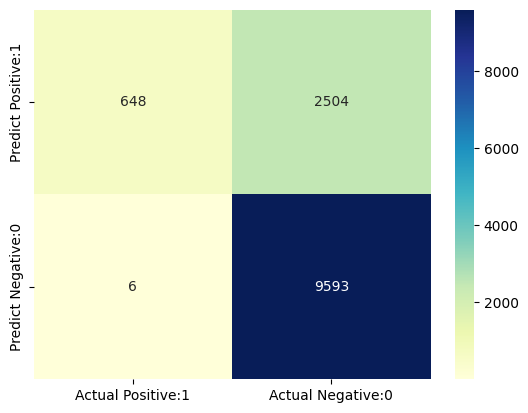

In [25]:
# visualizing confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<AxesSubplot:>

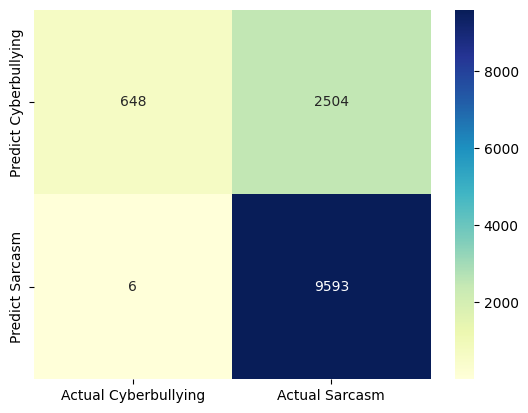

In [26]:
## Another confusion matrix with our labels, more understandable
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Cyberbullying', 'Actual Sarcasm'], 
                                 index=['Predict Cyberbullying', 'Predict Sarcasm'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

We have quiet high false positives (sarcastic comments predicted as cyberbullying). But the most important in our task is that we have very little number of false negatives (6), meaning bullying comments being classified as sarcasm.

## Making prediction on new sentences

In [29]:
# custom function
def my_prediction(my_sentence, model):
    #all_categories_names = np.array(merged_df.label)
    prediction = pipeline_naive_bayes.predict([my_sentence])
    return prediction

my_sentence = "I HATE YOU dumb ... swear to god"
print(my_prediction(my_sentence, pipeline_naive_bayes))

[1]


In [30]:
my_sentence = "well yeah"
print(my_prediction(my_sentence, pipeline_naive_bayes))

[0]


## Saving the modified dataset as a new csv file

In [32]:
merged_df.to_csv('merged_all_modified_csv.csv')